In [2]:
import pennylane as qml
import pandas as pd
from qco_level_0 import *
from qco_level_1 import optimization_level_1, optimization_level_1_df
from qco_level_2 import optimization_level_2
from qco_spec_table import show_circuit
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
[ds] = qml.data.load("ketgpt")

In [4]:
# example
seed = 3
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

qnode_q1 = optimization_level_1(circuit)
qnode_q2 = optimization_level_2(qnode_q1)
qnode_q1, df = optimization_level_1_df(qnode_q2)
df

,original,qiskit,penny,mine
gates,161,157,160,161
1q gates,76,76,74,76
2q gates,85,81,85,85
depth,66,67,66,66
gate types,6,6,7,6


In [5]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    obj = qml.specs(circuit)()['resources']
    try:
        qnode_q1 = optimization_level_1(circuit)
        qnode_q2 = optimization_level_2(qnode_q1)
        qnode_q1, df = optimization_level_1_df(qnode_q2)
        dfs.append(df)
    except:
        pass

c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWarning: invalid value encountered in arccos
  return func(*args, **kwargs)
c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWarning: invalid value encountered in arccos
  return func(*args, **kwargs)
c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWarning: invalid value encountered in arccos
  return func(*args, **kwargs)
c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWarning: invalid value encountered in arccos
  return func(*args, **kwargs)
c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWarning: invalid value encountered in arccos
  return func(*args, **kwargs)
c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWa

In [6]:
len(dfs)                                    

1000

In [7]:
dfs[0]

,original,qiskit,penny,mine
gates,56,56,51,51
1q gates,37,37,31,32
2q gates,19,19,19,19
depth,19,19,17,16
gate types,4,4,6,4


In [8]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    df = df.rename(columns={'qiskit':'Qiskit', 'penny':'PennyLane', 'mine':'Level 1+2+1'})
    dfs_ratio.append(df.div(df['original'], axis=0).round(3))
dfs_ratio = [df.drop(columns='original') for df in dfs_ratio]
dfs_ratio[0]

,Qiskit,PennyLane,Level 1+2+1
gates,1.0,0.911,0.911
1q gates,1.0,0.838,0.865
2q gates,1.0,1.000,1.000
depth,1.0,0.895,0.842
gate types,1.0,1.500,1.000


In [9]:
records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

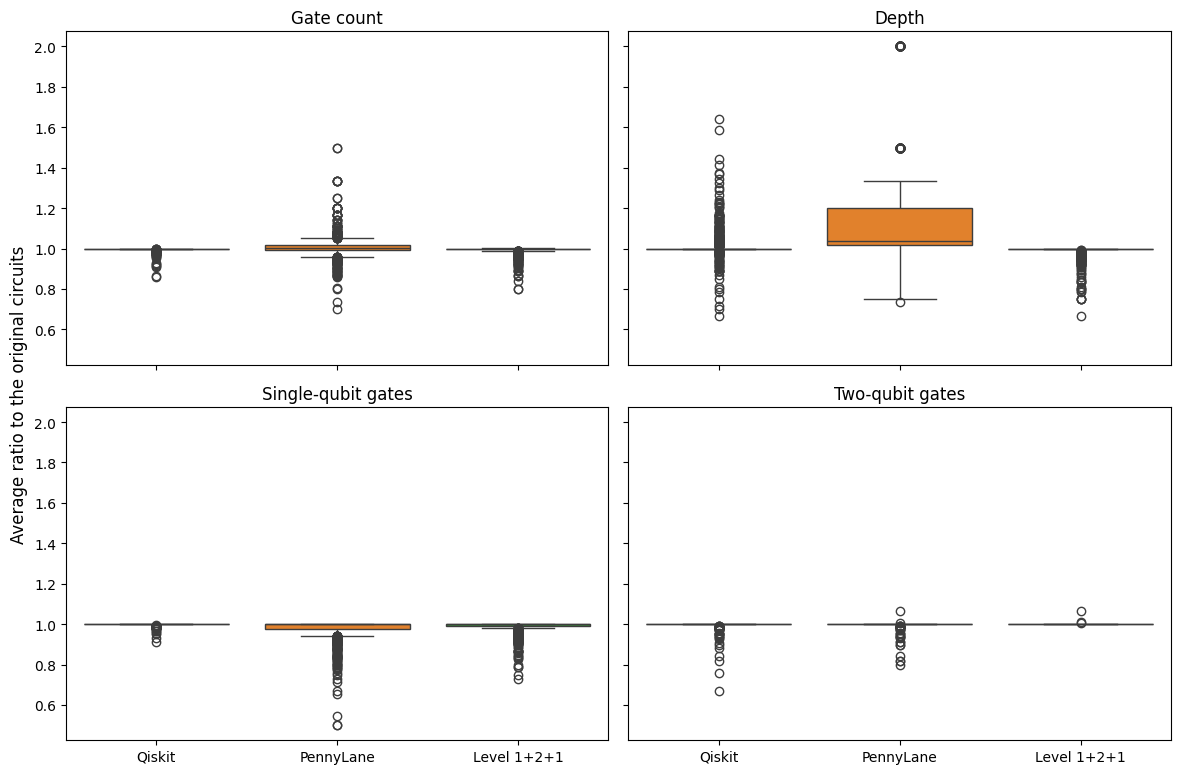

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for i, metric in enumerate(['gates','depth','1q gates', '2q gates']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'Level 1+2+1': '#2ca02c'})
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Depth')
    elif i==2:
        ax.set_title('Single-qubit gates')
    elif i==3:
        ax.set_title('Two-qubit gates')
    # ax.set_ylim(-0.1, 1.6)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('')  # Remove y-axis label

# fig.legend(handles, labels, loc='upper center', ncol=3, title='Method')
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

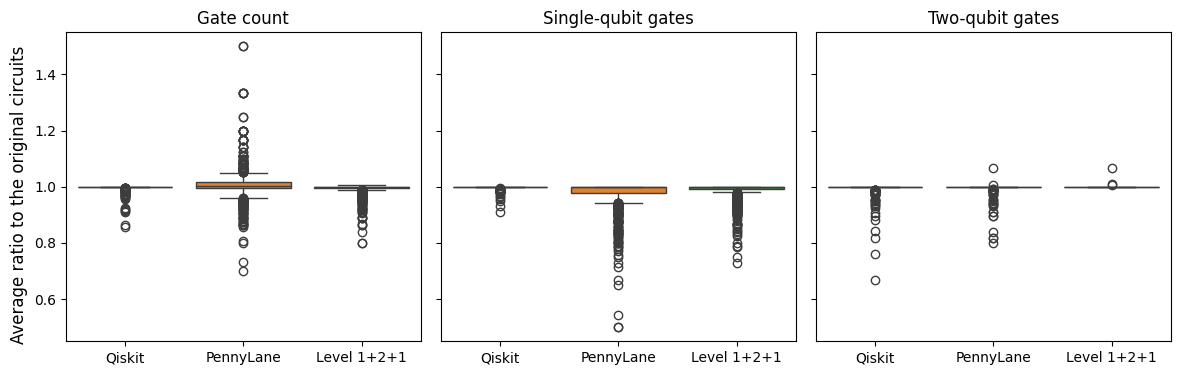

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for i, metric in enumerate(['gates', '1q gates', '2q gates']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'Level 1+2+1': '#2ca02c'})
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Single-qubit gates')
    elif i==2:
        ax.set_title('Two-qubit gates')
    # ax.set_ylim(-0.1, 1.6)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('')  # Remove y-axis label

# fig.legend(handles, labels, loc='upper center', ncol=3, title='Method')
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

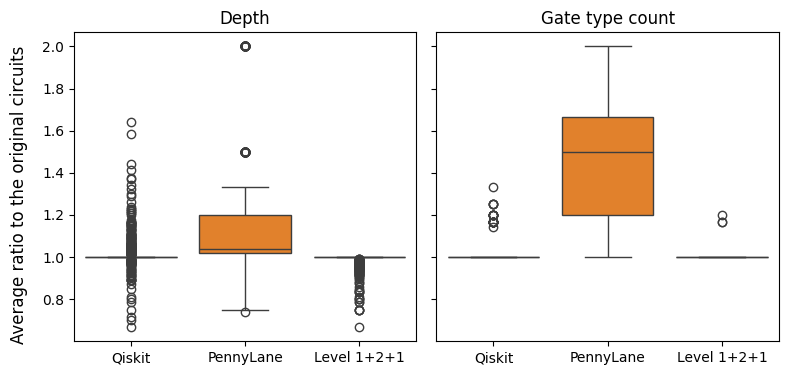

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

for i, metric in enumerate(['depth', 'gate types']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'Level 1+2+1': '#2ca02c'})
    if i==0:
        ax.set_title('Depth')
    elif i==1:
        ax.set_title('Gate type count')
    # ax.set_ylim(-0.1, 1.6)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('')  # Remove y-axis label

# fig.legend(handles, labels, loc='upper center', ncol=3, title='Method')
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

In [15]:
long_df.groupby(['method','metric'])['ratio'].agg(['mean']).reset_index()

,method,metric,mean
0,Level 1+2+1,1q gates,0.988292
1,Level 1+2+1,2q gates,1.000088
2,Level 1+2+1,depth,0.992402
3,Level 1+2+1,gate types,1.000534
4,Level 1+2+1,gates,0.993000
5,PennyLane,1q gates,0.977661
6,PennyLane,2q gates,0.998036
7,PennyLane,depth,1.150951
8,PennyLane,gate types,1.493249
9,PennyLane,gates,1.008613


In [16]:
long_df.groupby(['method','metric'])['ratio'].agg(['std']).reset_index()

,method,metric,std
0,Level 1+2+1,1q gates,0.029343
1,Level 1+2+1,2q gates,0.002220
2,Level 1+2+1,depth,0.030914
3,Level 1+2+1,gate types,0.009777
4,Level 1+2+1,gates,0.019297
5,PennyLane,1q gates,0.051133
6,PennyLane,2q gates,0.014758
7,PennyLane,depth,0.255947
8,PennyLane,gate types,0.274596
9,PennyLane,gates,0.054817


In [17]:
min_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean']).reset_index()
min_df['mean'] = (1-min_df['mean'])*100
min_df

,method,metric,mean
0,Level 1+2+1,1q gates,1.170800
1,Level 1+2+1,2q gates,-0.008779
2,Level 1+2+1,depth,0.759800
3,Level 1+2+1,gate types,-0.053400
4,Level 1+2+1,gates,0.700000
5,PennyLane,1q gates,2.233900
6,PennyLane,2q gates,0.196360
7,PennyLane,depth,-15.095100
8,PennyLane,gate types,-49.324900
9,PennyLane,gates,-0.861300
